In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l

d2l.gpu_mem_init()

2025-09-22 17:50:49.535507: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-22 17:50:49.599988: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-22 17:50:51.047444: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [2]:
def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(tf.keras.layers.Conv2D(num_channels, kernel_size=3, padding='same', activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [4]:
def vgg(conv_arch):
    net = tf.keras.models.Sequential()
    for num_conv,num_channel in conv_arch:
        net.add(vgg_block(num_conv, num_channel))
    net.add(tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10)
    ]))
    return net

In [5]:
vgg_net = vgg(conv_arch)

I0000 00:00:1758534652.117754 2817504 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31135 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:08.0, compute capability: 7.0


In [13]:
X = tf.random.uniform((1, 224, 224, 1))
for blk in vgg_net.layers:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 112, 112, 64)
Sequential output shape:	 (1, 56, 56, 128)
Sequential output shape:	 (1, 28, 28, 256)
Sequential output shape:	 (1, 14, 14, 512)
Sequential output shape:	 (1, 7, 7, 512)
Sequential output shape:	 (1, 10)


In [7]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
print(small_conv_arch)

[(1, 16), (1, 32), (2, 64), (2, 128), (2, 128)]


In [11]:
vgg_net_0 = lambda: vgg(small_conv_arch)

loss 0.171, train acc 0.937, test acc 0.920
2777.2 examples/sec on /GPU:0


<Sequential name=sequential_14, built=True>

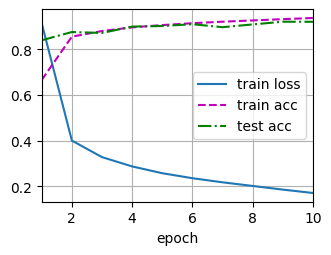

In [12]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(vgg_net_0, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())